# This colab notebook trains a classifier on the WBC-50 dataset using the pretrained weights from Cam16 and pRCC model


# Mount drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


# Unzipping dataset into colab instance

In [2]:
#Normal data
!unzip -q '/content/drive/MyDrive/WBC_50.zip' -d '/content/'

#On Balanced data
# !unzip -q '/content/drive/MyDrive/WBC_50_balanced.zip' -d '/content/'

# Test data
!unzip -q '/content/drive/MyDrive/WBC_test.zip' -d '/content/'

# Importing things

In [3]:
import os
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split, Subset, TensorDataset
import os
from torchvision.datasets import ImageFolder
from torch import nn, optim
from tqdm.auto import tqdm
import torchvision.models as models
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, ConfusionMatrixDisplay

# Parameters


In [4]:
class Config:
    drive_path = "/content/drive/MyDrive"
    datasets_path = f"/content/WBC_50"
    # Balanced
    # datasets_path = f"/content/WBC_50_balanced"
    eval_path = f"/content/WBC_test"

    weights_path = f"{drive_path}/weights"

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    test_split = 0.2
    validation_split = 0.3

    learning_rate = 0.01
    weight_decay = 1e-4
    grad_clip = 0.1

    pRCC_batch_size = 16
    pRCC_img_resize_target = 512  # from 2000 -> 512 ( Too big to fit on machine!)
    pRCC_latent_dim = 2048

    cam_batch_size = 16
    # cam_img_resize_target = 256 # from 384 -> 256
    cam_img_resize_target = 224 # as we are passing it into resnet

    wbc_batch_size = 16
    wbc_img_resize_target = 256 # from 575 -> 256

config = Config()

# Util functions


In [5]:
# Functions for plotting graphs
def plot_model_stats(experiment, epochs, training_losses, validation_losses, training_accuracy, validation_accuracy):
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    # Plot data on each subplot and add labels
    axes[0, 0].plot(epochs, training_losses, marker="o", color="red")
    axes[0, 0].set_title(f'{experiment}: Training Loss vs Epochs')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Training Loss')

    axes[0, 1].plot(epochs, training_accuracy, marker="o", color="green")
    axes[0, 1].set_title(f'{experiment}: Training Accuracy vs Epochs')
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Training Accuracy')

    axes[1, 0].plot(epochs, validation_losses, marker="o", color="red")
    axes[1, 0].set_title(f'{experiment}: Validation Loss vs Epochs')
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('Validation Loss')

    axes[1, 1].plot(epochs, validation_accuracy, marker="o", color="green")
    axes[1, 1].set_title(f'{experiment}: Validation Accuracy vs Epochs')
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('Validation Accuracy')

    # Add space between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

    # close it properly
    plt.clf()
    plt.cla()
    plt.close()

    # Show the plot
    plt.show()

    # close it properly
    plt.clf()
    plt.cla()
    plt.close()


# Functions needed for debugging dataset related issues

In [6]:
class LocalDebug:
    @staticmethod
    def create_mini_dataset(dataset, num_samples):
        '''
        Function to be used locally for checking if the model runs or not!

        :param dataset:
        :param num_samples:
        :return:
        '''
        subset_indices = torch.randperm(len(dataset))[:num_samples]
        subset_dataset = Subset(dataset, subset_indices)
        return subset_dataset

    @staticmethod
    def calculate_mean_and_std_of_dataset(dataset):
        '''
        Useful when determining what transforms to set

        :param dataset:
        :return:
        '''
        # dataset =  ImageFolder(root=self.path, transform=transforms.ToTensor())

        # Initialize variables to accumulate mean and standard deviation
        mean = torch.zeros(3)
        std = torch.zeros(3)

        # Loop through the dataset to compute mean and standard deviation
        for img, _ in dataset:
            mean += img.mean(1).mean(1)
            std += img.view(3, -1).std(1)

        # Calculate the mean and standard deviation
        mean /= len(dataset)
        std /= len(dataset)

        return (tuple(mean.tolist()), tuple(std.tolist()))

# Dataset wrapper to move tensors to device

In [7]:
'''
Wrapper on top of dataloader to move tensors to device
'''
class DeviceDataLoader(DataLoader):
    def __init__(self, dataset, batch_size, shuffle=True, device=config.device):
        super().__init__(
            dataset,
            batch_size=batch_size,
            shuffle=shuffle
        )
        self.device = device

    def __iter__(self):
        for batch in super().__iter__():
            yield self._move_to_device(batch)

    def _move_to_device(self, batch):
        if isinstance(batch, torch.Tensor):
            return batch.to(self.device)
        elif isinstance(batch, (list, tuple)):
            return [self._move_to_device(item) for item in batch]
        elif isinstance(batch, dict):
            return {key: self._move_to_device(value) for key, value in batch.items()}
        else:
            return batch



# Dataset


In [8]:
'''
Custom dataset for yielding the data as per different model input sizes
'''
class MedicalDataset(Dataset):
    def __init__(self,
                 dataset,
                 wbc_resize_to=config.wbc_img_resize_target,
                 cam_resize_to=config.cam_img_resize_target,
                 pRCC_resize_to=config.pRCC_img_resize_target
                 ):
        super().__init__()
        self.dataset = dataset
        # image resize sizes
        self.cam_resize_to = cam_resize_to
        self.pRCC_resize_to = pRCC_resize_to
        self.wbc_resize_to = wbc_resize_to

        # transformations
        self.wbc_resize_transform = transforms.Compose([
            transforms.Resize((self.wbc_resize_to, self.wbc_resize_to)),
            transforms.ToTensor()
        ])
        self.cam_resize_transform = self.resize_transformations(self.cam_resize_to)
        self.pRCC_resize_transform = self.resize_transformations(self.pRCC_resize_to)

    def resize_transformations(self, resize_to):
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((resize_to, resize_to)),
            transforms.ToTensor()
        ])
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data = self.dataset[idx]
        wbc_img_tensor, target_tensor = data
        wbc_img_tensor = wbc_img_tensor.squeeze()
        pRCC_img_tensor = self.pRCC_resize_transform(wbc_img_tensor)
        cam_img_tensor = self.cam_resize_transform(wbc_img_tensor)
        return pRCC_img_tensor, cam_img_tensor, wbc_img_tensor, target_tensor

In [9]:
class PretrainedWBCDataset:
    def __init__(self,
                 train_path,
                 eval_path,
                 eval_size=200,
                 val_split=config.validation_split,
                 batch_size=config.wbc_batch_size,
                 wbc_resize_to=config.wbc_img_resize_target,
                 take_subset=False
             ):
        # constants
        self.train_path = train_path
        self.eval_path = eval_path
        self.batch_size = batch_size
        self.val_split = val_split
        self.eval_size = eval_size
        self.take_subset = take_subset

        # paths
        self.train_path = os.path.join(self.train_path, "train", "data")
        self.eval_path = os.path.join(self.eval_path, "val", "data")

        self.wbc_resize_to = wbc_resize_to

        # transformations
        self.wbc_resize_transform = transforms.Compose([
            transforms.Resize((self.wbc_resize_to, self.wbc_resize_to)),
            transforms.ToTensor()
        ])

        # create dataset
        self.test_dataset, self.validation_dataset = self.get_test_val_datasets()
        self.train_dataset = self.get_train_dataset()
        print("Datasets are initialized")

    def get_train_dataset(self):
        unbalanced_dataset = ImageFolder(root=self.train_path, transform=self.wbc_resize_transform)
        print("constructing train dataset")
        return MedicalDataset(unbalanced_dataset)

    def get_test_val_datasets(self):
        image_folder = ImageFolder(root=self.eval_path, transform=self.wbc_resize_transform)
        # Calculate the number of samples to use for validation

        num_total_samples = len(image_folder)

        # find the no of train samples
        num_validation_samples = int(num_total_samples * self.val_split)
        num_test_samples = num_total_samples - num_validation_samples

        test_dataset, validation_dataset = random_split(image_folder, [num_test_samples, num_validation_samples])

        if self.take_subset:
            # find the no of train samples
            num_val_eval_samples = int(self.eval_size * self.val_split)
            num_test_eval_samples = self.eval_size - num_val_eval_samples

            test_dataset = LocalDebug.create_mini_dataset(test_dataset, num_test_eval_samples)
            validation_dataset = LocalDebug.create_mini_dataset(validation_dataset, num_val_eval_samples)

        print("constructing test & val dataset with augmentation")
        return MedicalDataset(test_dataset), MedicalDataset(validation_dataset)

    def get_dataloaders(self):
        '''

        :return: the Train, Val and test dataloaders
        '''

        # Create DataLoaders for validation and test sets
        return DeviceDataLoader(self.train_dataset, self.batch_size), \
            DeviceDataLoader(self.test_dataset, self.batch_size), \
            DeviceDataLoader(self.validation_dataset, self.batch_size)

# Generic Trainer


In [10]:
class Trainer:
    def __init__(self, name, dataset, model, save_dir, device=config.device):
        '''

        :param name: name of the experiement
        :param dataset: the dataset object which implements the method get_dataloaders()
        :param model: the model architecture used
        :param loss_criterion: the loss function used
        :param save_dir: path where the model weights can be saved
        '''
        self.name = name
        self.dataset = dataset
        self.save_dir = save_dir

        # create the directory if it doesnt exist!
        os.makedirs(self.save_dir, exist_ok=True)
        os.makedirs(os.path.join(self.save_dir, self.name), exist_ok=True)

        self.model = model
        self.device = device
        self.batch_size = self.dataset.batch_size

        # get loaders (each of which already moves tensors to device)
        self.train_loader, self.test_loader, self.val_loader = self.dataset.get_dataloaders()

        # Adam optimizer
        self.optimizer = optim.Adam(self.model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)

    # find the most recent file and return the path
    def get_model_checkpoint_path(self, epoch_num=None):
        directory = os.path.join(self.save_dir, self.name)
        if epoch_num == None:
            # Get a list of all files in the directory
            files = os.listdir(directory)

            # Filter out only the files (exclude directories)
            files = [f for f in files if os.path.isfile(os.path.join(directory, f))]

            # Sort the files by their modification time in descending order (most recent first)
            files.sort(key=lambda x: os.path.getmtime(os.path.join(directory, x)), reverse=True)

            # Get the name of the most recently added file
            model_file = files[0] if files else None
        else:
            model_file = f"model_epoch_{epoch_num}.pt"
        return os.path.join(directory, model_file)

    # main train code
    def train(self,
              num_epochs,
              resume_epoch_num=None,
              load_from_checkpoint=False,
              epoch_saver_count=2):
        '''

        :param num_epochs:
        :param resume_epoch_num: just the name of the model checkpoint
        :param load_from_checkpoint: boolean indicating if we need to load from checkpoint or not
        :param epoch_saver_count:
        :return:
        '''
        torch.cuda.empty_cache()

        # initialize the params from the saved checkpoint
        self.init_params_from_checkpoint_hook(load_from_checkpoint, resume_epoch_num)

        # set up scheduler
        self.init_scheduler_hook(num_epochs)

        # Custom progress bar for total epochs with color and displaying average epoch loss
        total_progress_bar = tqdm(
            total=num_epochs, desc=f"Total Epochs", position=0,
            bar_format="{desc}: {percentage}% |{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]",
            dynamic_ncols=True, ncols=100, colour='red'
        )

        # Train loop
        for epoch in range(self.start_epoch, self.start_epoch + num_epochs):
            # Custom progress bar for each epoch with color
            epoch_progress_bar = tqdm(
                total=len(self.train_loader),
                desc=f"Epoch {epoch + 1}/{self.start_epoch + num_epochs}",
                position=1,
                leave=False,
                dynamic_ncols=True,
                ncols=100,
                colour='green'
            )

            # set model to train mode
            self.model.train()

            # set the epoch training loss
            epoch_training_loss = 0.0

            # iterate over each batch
            for batch_idx, data in enumerate(self.train_loader):
                loss = self.calculate_loss_hook(data)
                loss.backward()

                # Gradient clipping
                nn.utils.clip_grad_value_(self.model.parameters(), config.grad_clip)

                self.optimizer.step()
                self.optimizer.zero_grad()

                # scheduler update
                if self.scheduler:
                    self.scheduler.step()

                # add to epoch loss
                epoch_training_loss += loss.item()

                # Update the epoch progress bar (overwrite in place)
                postfix = {
                    "loss": loss.item()
                }

                # e.g. computes things like accuracy
                batch_stats = self.calculate_train_batch_stats_hook()

                postfix.update(batch_stats)

                epoch_progress_bar.set_postfix(postfix)
                epoch_progress_bar.update(1)

            # close the epoch progress bar
            epoch_progress_bar.close()

            # calculate average epoch train statistics
            avg_train_stats = self.calculate_avg_train_stats_hook(epoch_training_loss)

            # calculate validation statistics
            avg_val_stats = self.validation_hook()

            # Store running history
            self.store_running_history_hook(epoch, avg_train_stats, avg_val_stats)

            # Show epoch stats (NOTE: Can clear the batch stats here)
            print(f"# Epoch {epoch+1}")
            epoch_postfix = self.calculate_and_print_epoch_stats_hook(avg_train_stats, avg_val_stats)


            # Update the total progress bar
            total_progress_bar.set_postfix(epoch_postfix)

            # Close tqdm bar
            total_progress_bar.update(1)

            # Save model checkpoint periodically
            need_to_save_model_checkpoint = (epoch + 1) % epoch_saver_count == 0
            if need_to_save_model_checkpoint:
                print(f"Going to save model {self.name} @ Epoch:{epoch + 1}")
                self.save_model_checkpoint_hook(epoch, avg_train_stats, avg_val_stats)

            print("-" * 60)

        # Close the total progress bar
        total_progress_bar.close()

        # Return the current state
        return self.get_current_running_history_state_hook()

    # hooks
    def init_params_from_checkpoint_hook(self, load_from_checkpoint, resume_checkpoint):
        raise NotImplementedError("Need to implement hook for initializing params from checkpoint")

    def init_scheduler_hook(self, num_epochs):
        # optimizer is already defined in the super class constructor at this point
        self.scheduler = torch.optim.lr_scheduler.OneCycleLR(
            self.optimizer,
            config.learning_rate,
            epochs=num_epochs,
            steps_per_epoch=len(self.train_loader)
        )
    def calculate_loss_hook(self, data):
        raise NotImplementedError("Need to implement hook for computing the custom loss value")

    def calculate_train_batch_stats_hook(self):
        raise NotImplementedError("Need to implement this hook for computing the batch statistics like accuracy")

    def calculate_avg_train_stats_hook(self):
        raise NotImplementedError(
            "Need to implement this hook for calculating train loss and train accuracy if applicable")

    def validation_hook(self):
        raise NotImplementedError("Need to implement this hook to calculate the validation stats")

    def calculate_and_print_epoch_stats_hook(self):
        raise NotImplementedError(
            "Need to implement this hook to calculate and print the epoch statistics and return the postfix dictinoary")

    def store_running_history_hook(self, epoch, avg_train_stats, avg_val_stats):
        raise NotImplementedError("Need to implement this hook to store the running history of stats for each epoch")

    def save_model_checkpoint_hook(self, epoch, avg_train_stats, avg_val_stats):
        raise NotImplementedError("Need to implement this hook to save the model checkpoints")

    def get_current_running_history_state_hook(self):
        raise NotImplementedError("Need to implement this hook to return the history after training the model")


# Subclassing the Generic Trainer for classification tasks

In [11]:
class ClassificationTrainer(Trainer):
    def __init__(self, name, dataset, model, save_dir, num_classes):
        super().__init__(name, dataset, model, save_dir)

        # structured similarity index
        self.loss_criterion = nn.CrossEntropyLoss()

        # Values which can change based on loaded checkpoint
        self.start_epoch = 0
        self.epoch_numbers = []
        self.training_losses = []
        self.training_accuracies = []
        self.validation_losses = []
        self.validation_accuracies = []

        self.num_classes = num_classes
        self.train_correct_predictions = 0
        self.train_total_batches = 0

    # hooks
    def init_params_from_checkpoint_hook(self, load_from_checkpoint, resume_epoch_num):
        if load_from_checkpoint:
            # NOTE: resume_epoch_num can be None here if we want to load from the most recently saved checkpoint!
            checkpoint_path = self.get_model_checkpoint_path(resume_epoch_num)
            checkpoint = torch.load(checkpoint_path)

            # load previous state
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

            # Things we are keeping track of
            self.start_epoch = checkpoint['epoch']
            self.epoch_numbers = checkpoint['epoch_numbers']
            self.training_losses = checkpoint['training_losses']
            self.validation_losses = checkpoint['validation_losses']
            self.training_accuracies = checkpoint['training_accuracies']
            self.validation_accuracies = checkpoint['validation_accuracies']

            print(f"Model checkpoint for {self.name} is loaded from {checkpoint_path}!")

    def calculate_train_batch_stats_hook(self):
        # Note: No accuracy to compute so leaving it as is.
        batch_stats = {
            "batch_acc": self.batch_accuracy
        }
        self.batch_accuracy = 0
        return batch_stats

    def calculate_avg_train_stats_hook(self, epoch_training_loss):
        # NOTE: no need to calculate avg training accuracy here
        avg_training_loss_for_epoch = epoch_training_loss / len(self.train_loader)
        avg_training_accuracy = self.train_correct_predictions / self.train_total_batches

        epoch_train_stats = {
            "avg_training_loss": avg_training_loss_for_epoch,
            "avg_training_accuracy": avg_training_accuracy
        }

        # reset
        self.train_correct_predictions = 0
        self.train_total_batches = 0

        return epoch_train_stats

    def store_running_history_hook(self, epoch, avg_train_stats, avg_val_stats):
        self.epoch_numbers.append(epoch + 1)
        self.training_losses.append(avg_train_stats["avg_training_loss"])
        self.training_accuracies.append(avg_train_stats["avg_training_accuracy"])

        self.validation_losses.append(avg_val_stats["avg_val_loss_for_epoch"])
        self.validation_accuracies.append(avg_val_stats["avg_val_accuracy"])

    def calculate_and_print_epoch_stats_hook(self, avg_train_stats, avg_val_stats):
        print(
            f"Epoch loss: {avg_train_stats['avg_training_loss']} | Train Acc: {avg_train_stats['avg_training_accuracy']} | Val Acc: {avg_val_stats['avg_val_accuracy']} | Val loss: {avg_val_stats['avg_val_loss_for_epoch']}")

        return {
            "epoch_loss": avg_train_stats['avg_training_loss'],
            "val_loss": avg_val_stats['avg_val_loss_for_epoch'],
            "train_acc": avg_train_stats['avg_training_accuracy'],
            "val_acc": avg_val_stats['avg_val_accuracy']
        }

    def save_model_checkpoint_hook(self, epoch, avg_train_stats, avg_val_stats):
        # set it to train mode to save the weights (but doesn't matter apparently!)
        self.model.train()

        # create the directory if it doesn't exist
        model_save_directory = os.path.join(self.save_dir, self.name)
        os.makedirs(model_save_directory, exist_ok=True)

        # Checkpoint the model at the end of each epoch
        checkpoint_path = os.path.join(model_save_directory, f'model_epoch_{epoch + 1}.pt')
        torch.save(
            {
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'epoch': epoch + 1,
                'epoch_numbers': self.epoch_numbers,
                'training_losses': self.training_losses,
                'training_accuracies': self.training_accuracies,
                'validation_losses': self.validation_losses,
                'validation_accuracies': self.validation_accuracies
            },
            checkpoint_path
        )
        print(f"Saved the model checkpoint for experiment {self.name} for epoch {epoch + 1}")

    def get_current_running_history_state_hook(self):
        return self.epoch_numbers, self.training_losses, self.training_accuracies, self.validation_losses, self.validation_accuracies

    # util code
    def one_hot(self, labels):
        # Create an empty one-hot tensor
        one_hot_tensor = torch.zeros((labels.size(0), self.num_classes), dtype=torch.float32).to(config.device)

        # Use scatter to fill in the one-hot tensor
        one_hot_tensor.scatter_(1, labels.view(-1, 1), 1)

        return one_hot_tensor

# WBC Trainer

In [12]:
class WBCClassifierTrainer(ClassificationTrainer):
    def __init__(self, name, dataset, model, save_dir, num_classes=5):
        super().__init__(name, dataset, model, save_dir, num_classes)
        # Class labels
        self.class_labels = {'Basophil': 0, 'Eosinophil': 1, 'Lymphocyte': 2, 'Monocyte': 3, 'Neutrophil': 4}
        # Prettify class labels
        self.class_names = list(self.class_labels.keys())

    # hooks
    def calculate_loss_hook(self, data):
        images, labels = data
        one_hot_labels = self.one_hot(labels)
        output_logits = self.model(images)
        loss = self.loss_criterion(output_logits, one_hot_labels)

        # compute the batch stats right here and save it
        output_probs = nn.Softmax(dim=1)(output_logits)
        predicted = torch.argmax(output_probs, 1)
        batch_correct_predictions = (predicted == labels).sum().item()
        batch_size = labels.size(0)

        # store the accuracies
        self.batch_accuracy = batch_correct_predictions / batch_size
        self.train_correct_predictions += batch_correct_predictions
        self.train_total_batches += labels.size(0)

        return loss

    def validation_hook(self):
        '''
        :return: avg val loss for that epoch
        '''
        val_loss = 0.0
        val_correct_predictions = 0
        total_val_samples = 0

        # set to eval mode
        self.model.eval()

        with torch.no_grad():
            for val_batch_idx, val_data in enumerate(self.val_loader):
                val_images, val_labels = val_data
                one_hot_val_labels = self.one_hot(val_labels)

                val_logits = self.model(val_images)

                val_loss += self.loss_criterion(val_logits, one_hot_val_labels).item()

                # Compute validation accuracy for this batch
                val_probs = nn.Softmax(dim=1)(val_logits)
                val_predicted = torch.argmax(val_probs, dim=1)
                total_val_samples += val_labels.size(0)
                val_correct_predictions += (val_predicted == val_labels).sum().item()

        # Calculate average validation loss for the epoch
        avg_val_loss_for_epoch = val_loss / len(self.val_loader)

        # Calculate validation accuracy for the epoch
        avg_val_accuracy = val_correct_predictions / total_val_samples

        return {
            "avg_val_loss_for_epoch": avg_val_loss_for_epoch,
            "avg_val_accuracy": avg_val_accuracy
        }

    def test_model(self):
        test_loss = 0.0
        test_correct_predictions = 0
        total_test_samples = 0

        # Initialize lists to store true labels and predicted labels
        true_labels = []
        predicted_labels = []

        # set to eval mode
        self.model.eval()

        with torch.no_grad():
            for test_batch_idx, test_data in enumerate(self.test_loader):
                test_images, test_labels = test_data
                one_hot_test_labels = self.one_hot(test_labels)

                test_logits = self.model(test_images)

                test_loss += self.loss_criterion(test_logits, one_hot_test_labels).item()

                # Compute validation accuracy for this batch
                test_probs = nn.Softmax(dim=1)(test_logits)
                test_predicted = torch.argmax(test_probs, dim=1)
                total_test_samples += test_labels.size(0)
                test_correct_predictions += (test_predicted == test_labels).sum().item()

                # Append true and predicted labels for each batch
                true_labels.extend(test_labels.cpu().numpy())
                predicted_labels.extend(test_predicted.cpu().numpy())

        # Calculate average validation loss for the epoch
        avg_test_loss = test_loss / len(self.test_loader)

        # Calculate validation accuracy for the epoch
        avg_test_accuracy = test_correct_predictions / total_test_samples

        conf_matrix, prettified_f1_scores, prettified_precision_scores, prettified_recall_scores = self.get_metrics_for_class_predictions(
            predicted_labels, true_labels
        )

        return {
            "test_loss": avg_test_loss,
            "test_accuracy": avg_test_accuracy,
            "conf_matrix": conf_matrix,
            "f1_scores": prettified_f1_scores,
            "recall_scores": prettified_recall_scores,
            "precision_scores": prettified_precision_scores
        }
    def get_metrics_for_class_predictions(self, predicted_labels, true_labels):
        # Calculate the confusion matrix
        conf_matrix = confusion_matrix(true_labels, predicted_labels)
        # Calculate F1 score, recall, and precision for each class
        f1_scores = f1_score(true_labels, predicted_labels, average=None)
        recall_scores = recall_score(true_labels, predicted_labels, average=None)
        precision_scores = precision_score(true_labels, predicted_labels, average=None)
        # Create dictionaries with prettified class labels
        prettified_f1_scores = {self.class_names[i]: f1_scores[i] for i in range(len(self.class_names))}
        prettified_recall_scores = {self.class_names[i]: recall_scores[i] for i in range(len(self.class_names))}
        prettified_precision_scores = {self.class_names[i]: precision_scores[i] for i in range(len(self.class_names))}
        # Print the confusion matrix with class labels
        self.print_confusion_matrix(conf_matrix)
        return conf_matrix, prettified_f1_scores, prettified_precision_scores, prettified_recall_scores

    def print_confusion_matrix(self, conf_matrix):
        print("Confusion Matrix")
        cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=self.class_names)
        cm_display.plot()
        plt.show()

# Trainer for the Pretrained WBC Classifier

In [26]:
class PretrainedWBCClassifierTrainer(WBCClassifierTrainer):
    def __init__(self, name, dataset, model, save_dir, num_classes=5):
        super().__init__(name, dataset, model, save_dir, num_classes)

        # Class labels
        self.class_labels = {'Basophil': 0, 'Eosinophil': 1, 'Lymphocyte': 2, 'Monocyte': 3, 'Neutrophil': 4}
        # Prettify class labels
        self.class_names = list(self.class_labels.keys())

    # hooks
    def calculate_loss_hook(self, data):
        pRCC_imgs, cam_imgs, wbc_imgs, labels = data
        one_hot_labels = self.one_hot(labels)

        output_logits = self.model(pRCC_imgs, cam_imgs, wbc_imgs)

        loss = self.loss_criterion(output_logits, one_hot_labels)

        # compute the batch stats right here and save it
        output_probs = nn.Softmax(dim=1)(output_logits)
        predicted = torch.argmax(output_probs, 1)
        batch_correct_predictions = (predicted == labels).sum().item()
        batch_size = labels.size(0)

        # store the accuracies
        self.batch_accuracy = batch_correct_predictions / batch_size
        self.train_correct_predictions += batch_correct_predictions
        self.train_total_batches += labels.size(0)

        return loss

    def validation_hook(self):
        '''
        :return: avg val loss for that epoch
        '''
        val_loss = 0.0
        val_correct_predictions = 0
        total_val_samples = 0

        # set to eval mode
        self.model.eval()

        with torch.no_grad():
            for val_batch_idx, val_data in enumerate(self.val_loader):
                val_pRCC_imgs, val_cam_imgs, val_wbc_imgs, val_labels = val_data
                one_hot_val_labels = self.one_hot(val_labels)

                val_logits = self.model(val_pRCC_imgs, val_cam_imgs, val_wbc_imgs)

                val_loss += self.loss_criterion(val_logits, one_hot_val_labels).item()

                # Compute validation accuracy for this batch
                val_probs = nn.Softmax(dim=1)(val_logits)
                val_predicted = torch.argmax(val_probs, dim=1)
                total_val_samples += val_labels.size(0)
                val_correct_predictions += (val_predicted == val_labels).sum().item()

        # Calculate average validation loss for the epoch
        avg_val_loss_for_epoch = val_loss / len(self.val_loader)

        # Calculate validation accuracy for the epoch
        avg_val_accuracy = val_correct_predictions / total_val_samples

        return {
            "avg_val_loss_for_epoch": avg_val_loss_for_epoch,
            "avg_val_accuracy": avg_val_accuracy
        }

    def test_model(self):
        test_loss = 0.0
        test_correct_predictions = 0
        total_test_samples = 0

        # Initialize lists to store true labels and predicted labels
        true_labels = []
        predicted_labels = []

        # set to eval mode
        self.model.eval()

        with torch.no_grad():
            for test_batch_idx, test_data in enumerate(self.test_loader):
                test_pRCC_imgs, test_cam_imgs, test_wbc_imgs, test_labels = test_data
                one_hot_test_labels = self.one_hot(test_labels)

                test_logits = self.model(test_pRCC_imgs, test_cam_imgs, test_wbc_imgs)

                test_loss += self.loss_criterion(test_logits, one_hot_test_labels).item()

                # Compute validation accuracy for this batch
                test_probs = nn.Softmax(dim=1)(test_logits)
                test_predicted = torch.argmax(test_probs, dim=1)
                total_test_samples += test_labels.size(0)
                test_correct_predictions += (test_predicted == test_labels).sum().item()

                # Append true and predicted labels for each batch
                true_labels.extend(test_labels.cpu().numpy())
                predicted_labels.extend(test_predicted.cpu().numpy())

        # Calculate average validation loss for the epoch
        avg_test_loss = test_loss / len(self.test_loader)

        # Calculate validation accuracy for the epoch
        avg_test_accuracy = test_correct_predictions / total_test_samples

        conf_matrix, prettified_f1_scores, prettified_precision_scores, prettified_recall_scores = self.get_metrics_for_class_predictions(
            predicted_labels, true_labels
        )

        return {
            "test_loss": avg_test_loss,
            "test_accuracy": avg_test_accuracy,
            "conf_matrix": conf_matrix,
            "f1_scores": prettified_f1_scores,
            "recall_scores": prettified_recall_scores,
            "precision_scores": prettified_precision_scores
        }

    def get_metrics_for_class_predictions(self, predicted_labels, true_labels):
        # Calculate the confusion matrix
        conf_matrix = confusion_matrix(true_labels, predicted_labels)
        # Calculate F1 score, recall, and precision for each class
        f1_scores = f1_score(true_labels, predicted_labels, average=None)
        recall_scores = recall_score(true_labels, predicted_labels, average=None)
        precision_scores = precision_score(true_labels, predicted_labels, average=None)
        # Create dictionaries with prettified class labels
        prettified_f1_scores = {self.class_names[i]: f1_scores[i] for i in range(len(self.class_names))}
        prettified_recall_scores = {self.class_names[i]: recall_scores[i] for i in range(len(self.class_names))}
        prettified_precision_scores = {self.class_names[i]: precision_scores[i] for i in range(len(self.class_names))}
        # Print the confusion matrix with class labels
        self.print_confusion_matrix(conf_matrix)
        return conf_matrix, prettified_f1_scores, prettified_precision_scores, prettified_recall_scores

    def print_confusion_matrix(self, conf_matrix):
        print("Confusion Matrix")
        cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=self.class_names)
        cm_display.plot()
        plt.show()

# All Previous Models


### WBC Base Model

In [27]:
class WBCClassifier(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()

        self.num_classes = num_classes

        self.conv1 = self.conv_and_batch_norm_block(3, 64, pool=True)
        self.conv2 = self.conv_and_batch_norm_block(64, 64, pool=True)
        self.res1 = self.conv_and_batch_norm_block(64, 64)
        self.res2 = self.conv_and_batch_norm_block(64, 64)

        self.conv3 = self.conv_and_batch_norm_block(64, 32, pool=True)
        self.conv4 = self.conv_and_batch_norm_block(32, 16, pool=True)
        self.res3 = self.conv_and_batch_norm_block(16, 16)
        self.res4 = self.conv_and_batch_norm_block(16, 16)

        self.classifier = nn.Sequential(
            #Input shape is (b, 16,16,16)
            # Convolutional layers to reduce spatial dimensions
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),  # Shape: (b, 8, 16, 16)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Shape: (b, 8, 8, 8)

            nn.Flatten(),  # Shape: (b, 64 * 4 * 4)

            # Linear layers with ReLU activation
            nn.Linear(8 * 8 * 8, 64),  # Shape: (b, 64)
            nn.ReLU(),  # Shape: (b, 64)

            nn.Linear(64, 8),  # Shape: (b, 32)
            nn.ReLU(),  # Shape: (b, 32)

            nn.Linear(8, self.num_classes)  # Final linear layer with output size 5 (for 5 classes)
        ).to(config.device)

    def conv_and_batch_norm_block(self, in_channels, out_channels, pool=False):
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]
        if pool:
            layers.append(nn.MaxPool2d(2))
        return nn.Sequential(*layers).to(config.device)


    def forward(self, x):
        out = self.conv1(x)  # shape (b,64,128,128)
        out1 = self.conv2(out)  # shape (b,64,64,64)
        out = self.res1(out1) + out1  # skip connections, shape (b,64,64,64)
        out = out1 + self.res2(out) + out  # multi skip connections, shape (b,64,64,64)

        out = self.conv3(out)  # shape is (b,32,32,32)
        out2 = self.conv4(out)  # shape is (b,16,16,16)
        out = self.res3(out2) + out2  # skip connections, shape is (b,16,16,16)
        out = out2 + self.res4(out) + out  # multi skip connections, shape is (b,16,16,16)

        out = self.classifier(out)
        return out

### pRCC autoencoder model


In [28]:
class pRCCAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()


        # Encoder
        self.encoder_conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1).to(config.device)
        self.encoder_conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1).to(config.device)
        self.encoder_conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1).to(config.device)
        # self.encoder_conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1).to(config.device)
        # self.encoder_conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1).to(config.device)
        # self.encoder_conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1).to(config.device)

        # Decoder
        self.decoder_conv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2).to(config.device)
        self.decoder_conv2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2).to(config.device)
        self.decoder_conv1 = nn.ConvTranspose2d(32, 3, kernel_size=2, stride=2).to(config.device)

        #Maxpool
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2).to(config.device)

        #Batch norms
        self.bn3 = nn.BatchNorm2d(3).to(config.device)
        self.bn32 = nn.BatchNorm2d(32).to(config.device)
        self.bn64 = nn.BatchNorm2d(64).to(config.device)
        self.bn128 = nn.BatchNorm2d(128).to(config.device)
        self.bn256 = nn.BatchNorm2d(256).to(config.device)

        #Activation
        self.relu = nn.ReLU().to(config.device)
        self.sigmoid = nn.Sigmoid().to(config.device)

    def forward(self, x):
        # Encoding
        x1_enc = self.encoder_conv1(x)# Shape: (batch_size, 32, 512, 512)
        # x1_enc = self.bn32(x1_enc)
        x1_enc = self.relu(x1_enc)
        x1_enc = self.maxpool(x1_enc) #Shape: (b, 32,256,256)

        x2_enc = self.encoder_conv2(x1_enc)  # Shape: (batch_size, 64, 256, 256)
        # x2_enc = self.bn64(x2_enc)
        x2_enc = self.relu(x2_enc)
        x2_enc = self.maxpool(x2_enc) # Shape: (batch_size, 64, 128, 128)

        x3_enc = self.encoder_conv3(x2_enc)  # Shape: (batch_size, 128, 128, 128)
        # x3_enc = self.bn128(x3_enc)
        x3_enc = self.relu(x3_enc)
        x3_enc = self.maxpool(x3_enc) # Shape: (batch_size, 128, 64, 64)


        # Decoding
        x3_dec = self.decoder_conv3(x3_enc)  # Shape: (batch_size, 64, 128, 128)
        # x5_dec = self.bn256(x5_dec)
        x3_dec = self.relu(x3_dec)

        x2_dec = self.decoder_conv2(x3_dec)  # Shape: (batch_size, 32, 256, 256)
        # x4_dec = self.bn128(x4_dec)
        x2_dec = self.relu(x2_dec)

        x1_dec = self.decoder_conv1(x2_dec)  # Shape: (batch_size, 3, 512, 512)
        # x1_dec = self.bn3(x1_dec)
        x1_dec = self.sigmoid(x1_dec)

        return x3_enc, x1_dec

### Camelyon 16 classifier model

In [29]:
class CamelyonClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()

        self.num_classes = num_classes

        self.conv1 = self.conv_and_batch_norm_block(3, 64)
        self.conv2 = self.conv_and_batch_norm_block(64, 128, pool=True)
        self.res1 = self.conv_and_batch_norm_block(128, 128)
        self.res2 = self.conv_and_batch_norm_block(128, 128)

        self.conv3 = self.conv_and_batch_norm_block(128, 256, pool=True)
        self.conv4 = self.conv_and_batch_norm_block(256, 512, pool=True)

        self.res3 = self.conv_and_batch_norm_block(512, 512)
        self.res4 = self.conv_and_batch_norm_block(512, 512)

        self.linear_stack = nn.Sequential(
            nn.MaxPool2d(4),
            nn.Flatten(),
            nn.Linear(32768, 2048),
            nn.ReLU(),
            nn.Linear(2048, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 5),
            nn.ReLU()
        )

        # Replace the initial layers with a pre-trained ResNet-18 backbone
        self.resnet18 = models.resnet18(pretrained=True)

        #set to non trainable
        self.resnet18.eval()
        for param in self.resnet18.parameters():
            param.requires_grad = False

        #remove the fully connected layer
        self.resnet18.fc = nn.Identity()  # Remove the fully connected layer (classifier)

        self.resnet_linear_stack = nn.Sequential(
            nn.Linear(512, 128),  # Adjust input size based on the output of ResNet-18
            nn.ReLU(),
            nn.Linear(128, 64),  # Adjust input size based on the output of ResNet-18
            nn.ReLU(),
            nn.Linear(64, 32),  # Adjust input size based on the output of ResNet-18
            nn.ReLU(),
            nn.Linear(32, 32),  # Adjust input size based on the output of ResNet-18
            nn.ReLU(),
            nn.Linear(32, 5),
            nn.Sigmoid()
        )

        self.predictor = nn.Sequential(
            nn.Linear(5, self.num_classes)
        )

    def conv_and_batch_norm_block(self, in_channels, out_channels, pool=False):
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]
        if pool:
            layers.append(nn.MaxPool2d(2))
        return nn.Sequential(*layers)

    def forward(self,x):
        # Pass input through the ResNet-18 backbone
        features = self.resnet18(x)

        # Continue with the linear stack and predictor
        linear_stack = self.resnet_linear_stack(features)
        predictor = self.predictor(linear_stack)
        return linear_stack, predictor

    def old_forward(self, x):
        '''
        This contains the old model architecture

        :param x:
        :return:
        '''
        #Assumes that x is of shape (b, 3, 256,256)
        out = self.conv1(x)  # shape (b,64,256,256)
        out1 = self.conv2(out)  # shape (b,128,128,128)
        out = self.res1(out1) + out1  # skip connections, shape (b,128,128,128)

        out = out1 + self.res2(out) + out  # multi skip connections, shape (b,128,128,128)
        out = self.conv3(out)  # shape is (b,256,64,64)
        out2 = self.conv4(out)  # shape is (b,512,32,32)

        out = self.res3(out2) + out2  # skip connections, shape is (b,512,32,32)
        out = out2 + self.res4(out) + out  # multi skip connections, shape is (b,512,32,32)

        linear_stack = self.linear_stack(out)
        predictor = self.predictor(linear_stack)
        return linear_stack, predictor

### Combined model

In [30]:
class PretrainedWBCClassifier(nn.Module):
    def __init__(self,
                 pRCC_model,
                 Cam16_model,
                 WBC_model,
                 pRCC_weights_path=None,
                 cam_weights_path=None,
                 wbc_weights_path=None
                 ):
        super().__init__()

        self.pRCC_model = pRCC_model.to(config.device)
        self.Cam16_model = Cam16_model.to(config.device)
        self.WBC_model = WBC_model.to(config.device)

        if pRCC_weights_path:
            print(f"Loading the pRCC weights from {pRCC_weights_path}")
            pRCC_checkpoint = torch.load(pRCC_weights_path, map_location=config.device)
            print(f"Retrieved the pRCC Checkpoint file!")
            print(f"Keys present in this checkpoint are {pRCC_checkpoint.keys()}")
            # Load the best weights for the pRCC model and make it non-trainable
            self.pRCC_model.load_state_dict(pRCC_checkpoint['model_state_dict'])
            print(f"Finished loading the pRCC weights from {pRCC_weights_path}")
            self.pRCC_model.eval()
            for param in self.pRCC_model.parameters():
                param.requires_grad = False
            print(f"Setting the pRCC model to eval mode and non trainable!")

        if cam_weights_path:
            print(f"Loading the Camelyon weights from {cam_weights_path}")
            # Load the best weights for the Cam16 model and make it non-trainable
            cam_checkpoint = torch.load(cam_weights_path, map_location=config.device)
            print(f"Retrieved the Camelyon Checkpoint file!")
            print(f"Keys present in this checkpoint are {cam_checkpoint.keys()}")
            self.Cam16_model.load_state_dict(cam_checkpoint['model_state_dict'])
            print(f"Finished loading the Camelyon weights from {cam_weights_path}")
            self.Cam16_model.eval()
            for param in self.Cam16_model.parameters():
                param.requires_grad = False
            print(f"Setting the Camelyon model to eval mode and non trainable!")

        if wbc_weights_path:
            print(f"Loading the base WBC weights from {wbc_weights_path}")
            # Load the best weights for the WBC model (which remains trainable)
            wbc_checkpoint = torch.load(wbc_weights_path, map_location=config.device)
            print(f"Retrieved the WBC Checkpoint file!")
            print(f"Keys present in this checkpoint are {wbc_checkpoint.keys()}")
            self.WBC_model.load_state_dict(wbc_checkpoint)
            print(f"Finished loading the base WBC weights from {wbc_weights_path}")

        #Input (batch_size, 128, 64, 64)
        self.pRCC_latent_to_output = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # Output shape: (batch_size, 256, 64, 64)
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output shape: (batch_size, 256, 32, 32)
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),  # Output shape: (batch_size, 128, 32, 32)
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output shape: (batch_size, 128, 16, 16)
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),  # Output shape: (batch_size, 64, 16, 16)
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output shape: (batch_size, 64, 8, 8)
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),  # Output shape: (batch_size, 32, 8, 8)
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output shape: (batch_size, 32, 4, 4)
            nn.Flatten(),  # Output shape: (batch_size, 32 * 4 * 4)
            nn.Linear(32 * 4 * 4, 5)  # Output shape: (batch_size, 5)
        ).to(config.device)

        # Additional linear layer to combine the outputs of all three models (5 + 5 + 5)
        self.combine_outputs = nn.Linear(5, 5).to(config.device)

    def forward(self, pRCC_input, Cam16_input, WBC_input):
        # Forward pass through pRCC model
        pRCC_latent, _ = self.pRCC_model(pRCC_input)
        pRCC_output = self.pRCC_latent_to_output(pRCC_latent)

        # Forward pass through Cam16 model ( the second one is the prediction across 2 classes)
        Cam16_output, _ = self.Cam16_model(Cam16_input)

        # Forward pass through WBC model
        WBC_output = self.WBC_model(WBC_input)

        # Combine the outputs from each of the model
        combined_output = pRCC_output + Cam16_output + WBC_output

        # Combine the outputs of all three models
        combined_predictor = self.combine_outputs(combined_output)

        return combined_predictor

# Creating the dataset

In [31]:
path = os.path.abspath(config.datasets_path)
eval_path = os.path.abspath(config.eval_path)
pretrained_wbc_dataset = PretrainedWBCDataset(path, eval_path)

constructing test & val dataset with augmentation
constructing train dataset
Datasets are initialized


# Training code

In [32]:
# initialize other models
pRCC_model = pRCCAutoencoder()
cam_model = CamelyonClassifier()
wbc_model = WBCClassifier()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [33]:
# get the paths of the best saved models
pRCC_weights_path = os.path.join(config.weights_path, "pRCC_Autoencoder", "model_epoch_20.pt")
cam_weights_path = os.path.join(config.weights_path, "camelyon_classifier", "model_epoch_52.pt")
wbc_weights_path = os.path.join(config.weights_path, "wbc_50_base", "model_epoch_10.pt")

In [34]:
name = "wbc_50_pretrained"
pretrained_model = PretrainedWBCClassifier(
    pRCC_model = pRCC_model,
    Cam16_model = cam_model,
    WBC_model = wbc_model,
    pRCC_weights_path=pRCC_weights_path,
    cam_weights_path=cam_weights_path,
    wbc_weights_path=None
    # wbc_weights_path=wbc_weights_path #If at all we want to take the already best saved model
).to(config.device)
save_dir = os.path.abspath(config.weights_path)
pretrained_wbc_trainer = PretrainedWBCClassifierTrainer(name, pretrained_wbc_dataset, pretrained_model, save_dir)

Loading the pRCC weights from /content/drive/MyDrive/weights/pRCC_Autoencoder/model_epoch_20.pt
Retrieved the pRCC Checkpoint file!
Keys present in this checkpoint are dict_keys(['model_state_dict', 'optimizer_state_dict', 'epoch', 'epoch_numbers', 'training_losses', 'validation_losses'])
Finished loading the pRCC weights from /content/drive/MyDrive/weights/pRCC_Autoencoder/model_epoch_20.pt
Setting the pRCC model to eval mode and non trainable!
Loading the Camelyon weights from /content/drive/MyDrive/weights/camelyon_classifier/model_epoch_52.pt
Retrieved the Camelyon Checkpoint file!
Keys present in this checkpoint are dict_keys(['model_state_dict', 'optimizer_state_dict', 'epoch', 'epoch_numbers', 'training_losses', 'training_accuracies', 'validation_losses', 'validation_accuracies'])
Finished loading the Camelyon weights from /content/drive/MyDrive/weights/camelyon_classifier/model_epoch_52.pt
Setting the Camelyon model to eval mode and non trainable!


In [22]:
epoch_numbers, training_losses, training_accuracies, validation_losses, validation_accuracies = pretrained_wbc_trainer.train(14, epoch_saver_count=1)

Total Epochs: 0.0% |          | 0/14 [00:00<?, ?it/s]

Epoch 1/14:   0%|          | 0/581 [00:00<?, ?it/s]

# Epoch 1
Epoch loss: 0.39514939100024726 | Train Acc: 0.8631714931639574 | Val Acc: 0.9015444015444015 | Val loss: 0.25143299157251464
Going to save model wbc_100_pretrained @ Epoch:1
Saved the model checkpoint for experiment wbc_100_pretrained for epoch 1
------------------------------------------------------------


Epoch 2/14:   0%|          | 0/581 [00:00<?, ?it/s]

# Epoch 2
Epoch loss: 0.2874218972396625 | Train Acc: 0.9033265152330714 | Val Acc: 0.8474903474903475 | Val loss: 0.41415607330925536
Going to save model wbc_100_pretrained @ Epoch:2
Saved the model checkpoint for experiment wbc_100_pretrained for epoch 2
------------------------------------------------------------


Epoch 3/14:   0%|          | 0/581 [00:00<?, ?it/s]

# Epoch 3
Epoch loss: 0.2718055434527017 | Train Acc: 0.9090321886101841 | Val Acc: 0.9343629343629344 | Val loss: 0.16957700159400702
Going to save model wbc_100_pretrained @ Epoch:3
Saved the model checkpoint for experiment wbc_100_pretrained for epoch 3
------------------------------------------------------------


Epoch 4/14:   0%|          | 0/581 [00:00<?, ?it/s]

# Epoch 4
Epoch loss: 0.2524762973495921 | Train Acc: 0.9139842824846592 | Val Acc: 0.9401544401544402 | Val loss: 0.14763721350975562
Going to save model wbc_100_pretrained @ Epoch:4
Saved the model checkpoint for experiment wbc_100_pretrained for epoch 4
------------------------------------------------------------


Epoch 5/14:   0%|          | 0/581 [00:00<?, ?it/s]

# Epoch 5
Epoch loss: 0.21568219369219652 | Train Acc: 0.9291635267520724 | Val Acc: 0.9401544401544402 | Val loss: 0.15553843342896664
Going to save model wbc_100_pretrained @ Epoch:5
Saved the model checkpoint for experiment wbc_100_pretrained for epoch 5
------------------------------------------------------------


Epoch 6/14:   0%|          | 0/581 [00:00<?, ?it/s]

# Epoch 6
Epoch loss: 0.20991792814445337 | Train Acc: 0.9321778447626224 | Val Acc: 0.9575289575289575 | Val loss: 0.11808771032100952
Going to save model wbc_100_pretrained @ Epoch:6
Saved the model checkpoint for experiment wbc_100_pretrained for epoch 6
------------------------------------------------------------


Epoch 7/14:   0%|          | 0/581 [00:00<?, ?it/s]

# Epoch 7
Epoch loss: 0.18104596875239837 | Train Acc: 0.9408978361502853 | Val Acc: 0.9362934362934363 | Val loss: 0.1904584970466341
Going to save model wbc_100_pretrained @ Epoch:7
Saved the model checkpoint for experiment wbc_100_pretrained for epoch 7
------------------------------------------------------------


Epoch 8/14:   0%|          | 0/581 [00:00<?, ?it/s]

# Epoch 8
Epoch loss: 0.14776228588148985 | Train Acc: 0.9501560986112606 | Val Acc: 0.9420849420849421 | Val loss: 0.18966278089404418
Going to save model wbc_100_pretrained @ Epoch:8
Saved the model checkpoint for experiment wbc_100_pretrained for epoch 8
------------------------------------------------------------


Epoch 9/14:   0%|          | 0/581 [00:00<?, ?it/s]

# Epoch 9
Epoch loss: 0.12649517201875957 | Train Acc: 0.958983744213586 | Val Acc: 0.9555984555984556 | Val loss: 0.14319670141258306
Going to save model wbc_100_pretrained @ Epoch:9
Saved the model checkpoint for experiment wbc_100_pretrained for epoch 9
------------------------------------------------------------


Epoch 10/14:   0%|          | 0/581 [00:00<?, ?it/s]

# Epoch 10
Epoch loss: 0.07631519954832611 | Train Acc: 0.9738400258370116 | Val Acc: 0.9536679536679536 | Val loss: 0.12828518910629844
Going to save model wbc_100_pretrained @ Epoch:10
Saved the model checkpoint for experiment wbc_100_pretrained for epoch 10
------------------------------------------------------------


Epoch 11/14:   0%|          | 0/581 [00:00<?, ?it/s]

# Epoch 11
Epoch loss: 0.04794264567552368 | Train Acc: 0.9840671762299494 | Val Acc: 0.9652509652509652 | Val loss: 0.144337237486263
Going to save model wbc_100_pretrained @ Epoch:11
Saved the model checkpoint for experiment wbc_100_pretrained for epoch 11
------------------------------------------------------------


Epoch 12/14:   0%|          | 0/581 [00:00<?, ?it/s]

# Epoch 12
Epoch loss: 0.020147627842286516 | Train Acc: 0.9928948218322747 | Val Acc: 0.9691119691119691 | Val loss: 0.11902894659179407
Going to save model wbc_100_pretrained @ Epoch:12
Saved the model checkpoint for experiment wbc_100_pretrained for epoch 12
------------------------------------------------------------


Epoch 13/14:   0%|          | 0/581 [00:00<?, ?it/s]

# Epoch 13
Epoch loss: 0.0057704206292039685 | Train Acc: 0.9991387662826999 | Val Acc: 0.9633204633204633 | Val loss: 0.12438558144198066
Going to save model wbc_100_pretrained @ Epoch:13
Saved the model checkpoint for experiment wbc_100_pretrained for epoch 13
------------------------------------------------------------


Epoch 14/14:   0%|          | 0/581 [00:00<?, ?it/s]

# Epoch 14
Epoch loss: 0.0027743880965961695 | Train Acc: 0.999784691570675 | Val Acc: 0.9633204633204633 | Val loss: 0.12889084783725566
Going to save model wbc_100_pretrained @ Epoch:14
Saved the model checkpoint for experiment wbc_100_pretrained for epoch 14
------------------------------------------------------------


## Training for more epochs if required

In [ ]:
# epoch_numbers, training_losses, training_accuracies, validation_losses, validation_accuracies = pretrained_wbc_trainer.train(10, epoch_saver_count=2, load_from_checkpoint=True, resume_epoch_num=42)

# Testing the model

Confusion Matrix


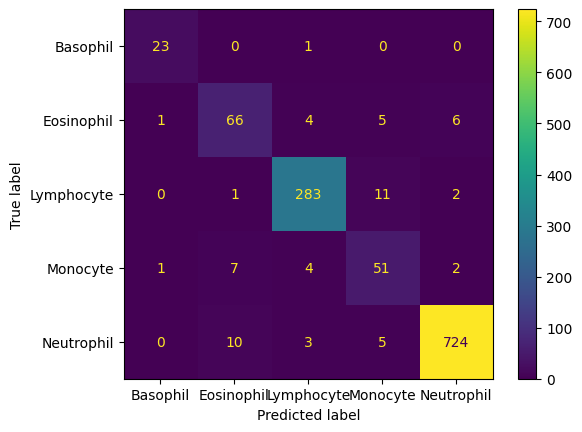

In [36]:
test_stats = pretrained_wbc_trainer.test_model()

In [37]:
print(f"Test Loss: {test_stats['test_loss']} | Test Accuracy: {test_stats['test_accuracy']}")

Test Loss: 0.21454064454261948 | Test Accuracy: 0.9479338842975207


In [38]:
test_stats['conf_matrix']

array([[ 23,   0,   1,   0,   0],
       [  1,  66,   4,   5,   6],
       [  0,   1, 283,  11,   2],
       [  1,   7,   4,  51,   2],
       [  0,  10,   3,   5, 724]])

Confusion Matrix


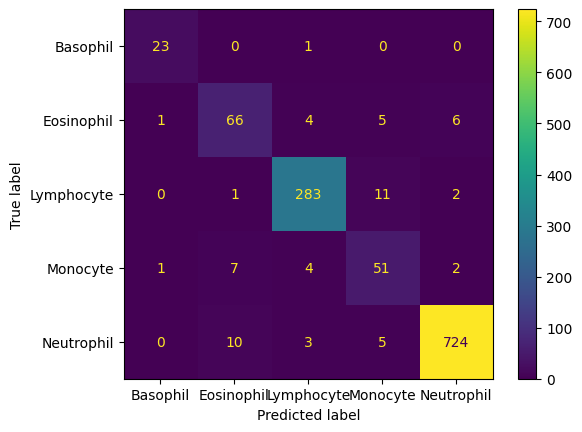

In [39]:
pretrained_wbc_trainer.print_confusion_matrix(test_stats['conf_matrix'])

In [40]:
print("F1 scores")
test_stats['f1_scores']

F1 scores


{'Basophil': 0.9387755102040817,
 'Eosinophil': 0.7951807228915663,
 'Lymphocyte': 0.956081081081081,
 'Monocyte': 0.7445255474452555,
 'Neutrophil': 0.981029810298103}

In [41]:
print("Precision scores")
test_stats['precision_scores']

Precision scores


{'Basophil': 0.92,
 'Eosinophil': 0.7857142857142857,
 'Lymphocyte': 0.9593220338983051,
 'Monocyte': 0.7083333333333334,
 'Neutrophil': 0.9863760217983651}

In [42]:
print("Recall scores")
test_stats['recall_scores']

Recall scores


{'Basophil': 0.9583333333333334,
 'Eosinophil': 0.8048780487804879,
 'Lymphocyte': 0.9528619528619529,
 'Monocyte': 0.7846153846153846,
 'Neutrophil': 0.9757412398921833}

# Plotting the graphs

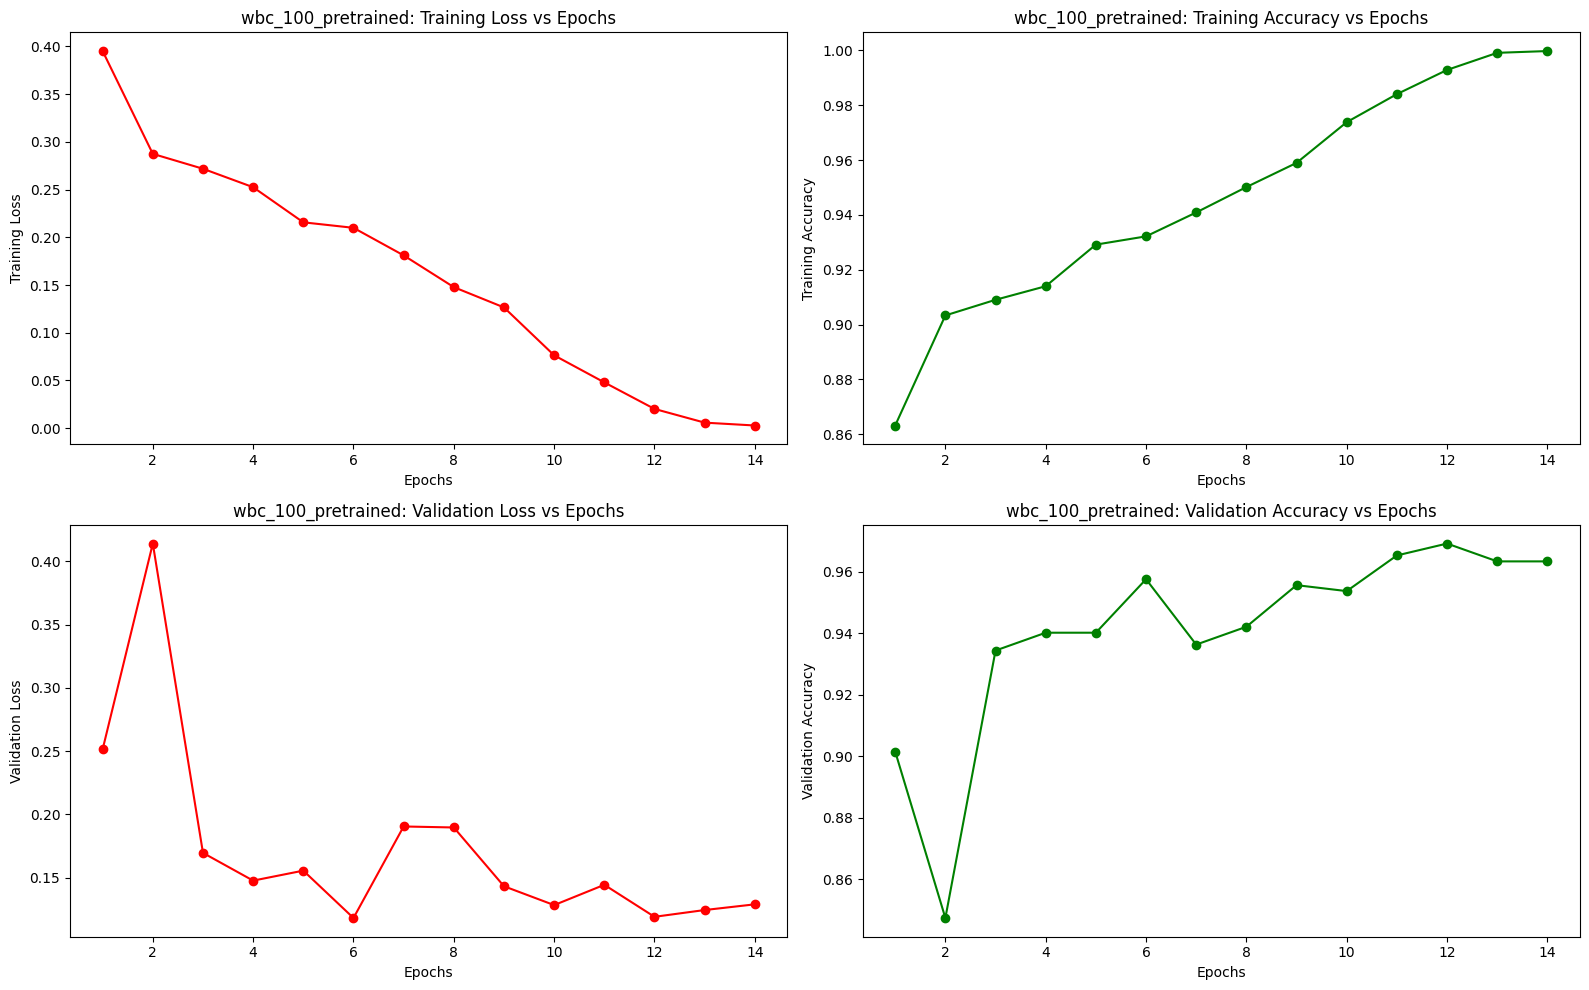

In [25]:
plot_model_stats(name, epoch_numbers, training_losses, validation_losses, training_accuracies, validation_accuracies)